## Machine learning to create a Trading Algorithim

In this project We are trying to predict the buy and sell price for APPL using ML by using lots of variable that can impact prediction. We are aming to achive a average score that is highet then random guessig.

In [1]:
#Importing Required Libraries

import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime, timedelta
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrameUnit, TimeFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

Setting up API

In [2]:
load_dotenv()
#Set API and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")


Setting API Parameters to download sticker date

In [3]:
#Selecting ticker
ticker = "AAPL"

#Set timeframe
timeframe = TimeFrame(15, TimeFrameUnit.Minute)

#Setting date for latest date available from APIO
now = pd.Timestamp(datetime.now().date() - timedelta(days=2))

#Caculate the start date 
start_date = (now - timedelta(days=365*10)).date().isoformat()

#Downloading historial data from API
df_ticker = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
).df

# Rename index to "Date"
df_ticker.index.name = 'Date'

In [4]:
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap
Date,,,,,,,
2015-12-01 09:00:00+00:00,118.88,118.94,118.88,118.94,1145,5,118.902052
2015-12-01 09:15:00+00:00,118.77,118.77,118.77,118.77,200,1,118.770000
2015-12-01 09:30:00+00:00,118.69,118.69,118.60,118.60,900,4,118.610000
2015-12-01 09:45:00+00:00,118.64,118.65,118.64,118.65,3580,5,118.648883
2015-12-01 10:00:00+00:00,118.65,118.65,118.55,118.55,1820,4,118.611538


### Generating the Technical Indicators and Custom trading signals by the help of the features.

In [5]:
indicators_df = pd.DataFrame()

indicators_df['Close'] = df_ticker['close']

# Calculate daily returns
indicators_df['Actual Returns'] = df_ticker['close'].pct_change()

#defining short and long window to caculaute EMA
short_window = 100
long_window = 200

# Caulcualating the EMA technical indicators for the short and long windows
indicators_df["Short"] = TA.EMA(df_ticker, short_window)
indicators_df["Long"] = TA.EMA(df_ticker, long_window)

#Caculuating the RSI indicator
indicators_df["RSI"] = TA.RSI(df_ticker)

# Calculate the upper and lower Bollinger Bands
indicators_df['20 Day MA'] = df_ticker['close'].rolling(window=20).mean()
indicators_df['Upper Band'] = indicators_df['20 Day MA'] + 2 * df_ticker['close'].rolling(window=20).std()
indicators_df['Lower Band'] = indicators_df['20 Day MA'] - 2 * df_ticker['close'].rolling(window=20).std()


In [6]:
indicators_df.head()

,Close,Actual Returns,Short,Long,RSI,20 Day MA,Upper Band,Lower Band
Date,,,,,,,,
2015-12-01 09:00:00+00:00,118.94,NaN,118.940000,118.940000,NaN,NaN,NaN,NaN
2015-12-01 09:15:00+00:00,118.77,-0.001429,118.854150,118.854575,0.000000,NaN,NaN,NaN
2015-12-01 09:30:00+00:00,118.60,-0.001431,118.767733,118.768867,0.000000,NaN,NaN,NaN
2015-12-01 09:45:00+00:00,118.65,0.000422,118.737411,118.738703,14.106809,NaN,NaN,NaN
2015-12-01 10:00:00+00:00,118.55,-0.000843,118.698415,118.700204,10.819441,NaN,NaN,NaN


#### Finding the correalation between the variables

Here we are performing the correlation matrix and visualizing them on a heat map to figure out whcih variables are less correlated.

If the correaltion:
- Is between 0.0 and -0.3, they have a week correlation.
- Is between -0.3 and -0.5 they have a moderate correlation.
- Is between 0.5 and -1 they have a high correlation.
- is between 0.0 and 0.3 they have a week correlation.
- Is between 0.3 and 0.5 they have a moderate correlation.
- Is between0.5 and 1 they have a high correlation.

<AxesSubplot:>

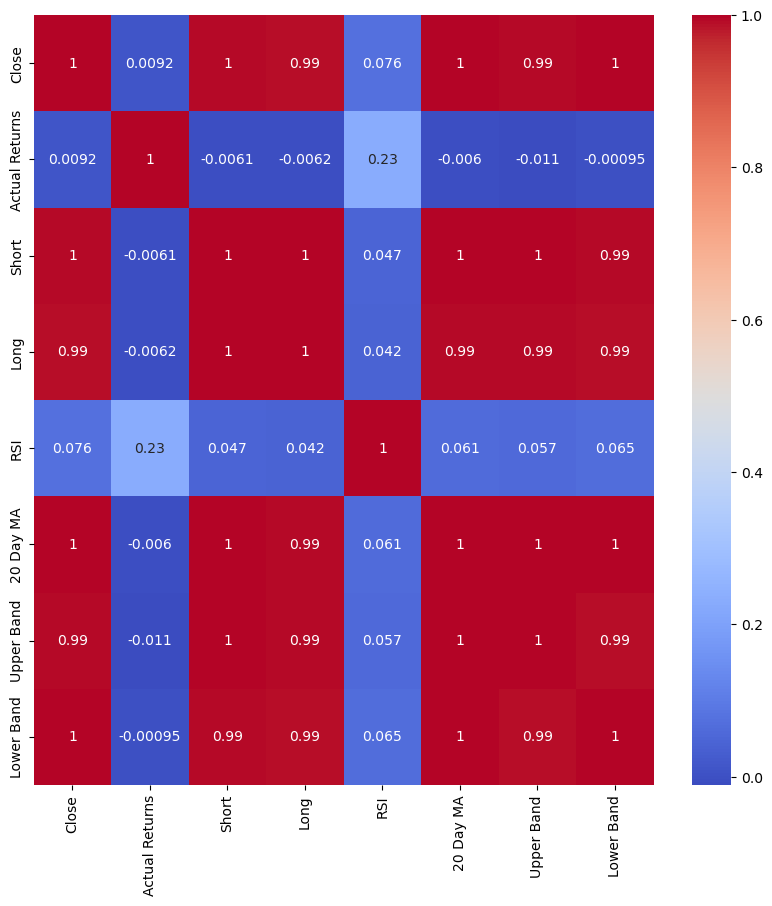

In [7]:
# Generate the correlation matrix
corr_matrix = indicators_df.dropna().corr()

# Generate the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    corr_matrix,
    annot=True, 
    cmap='coolwarm',
    ax=ax
    )

In [15]:
# Trading Rules - buy, hold, and sell signals based on the RSI indicator
for i, row in indicators_df.iterrows():
    # Buy Signal
    if row['RSI'] < 30:
        indicators_df.loc[i, 'Buy Signal'] = 1
    # Sell Signal
    elif row['RSI'] > 70:
        indicators_df.loc[i, 'Buy Signal'] = -1
    else:
        # Hold
        indicators_df.loc[i, 'Buy Signal'] = 0


In [16]:
#Count buy, sell and hold values
indicators_df['Buy Signal'].value_counts()

 0.0    98238
-1.0     8851
 1.0     6461
Name: Buy Signal, dtype: int64

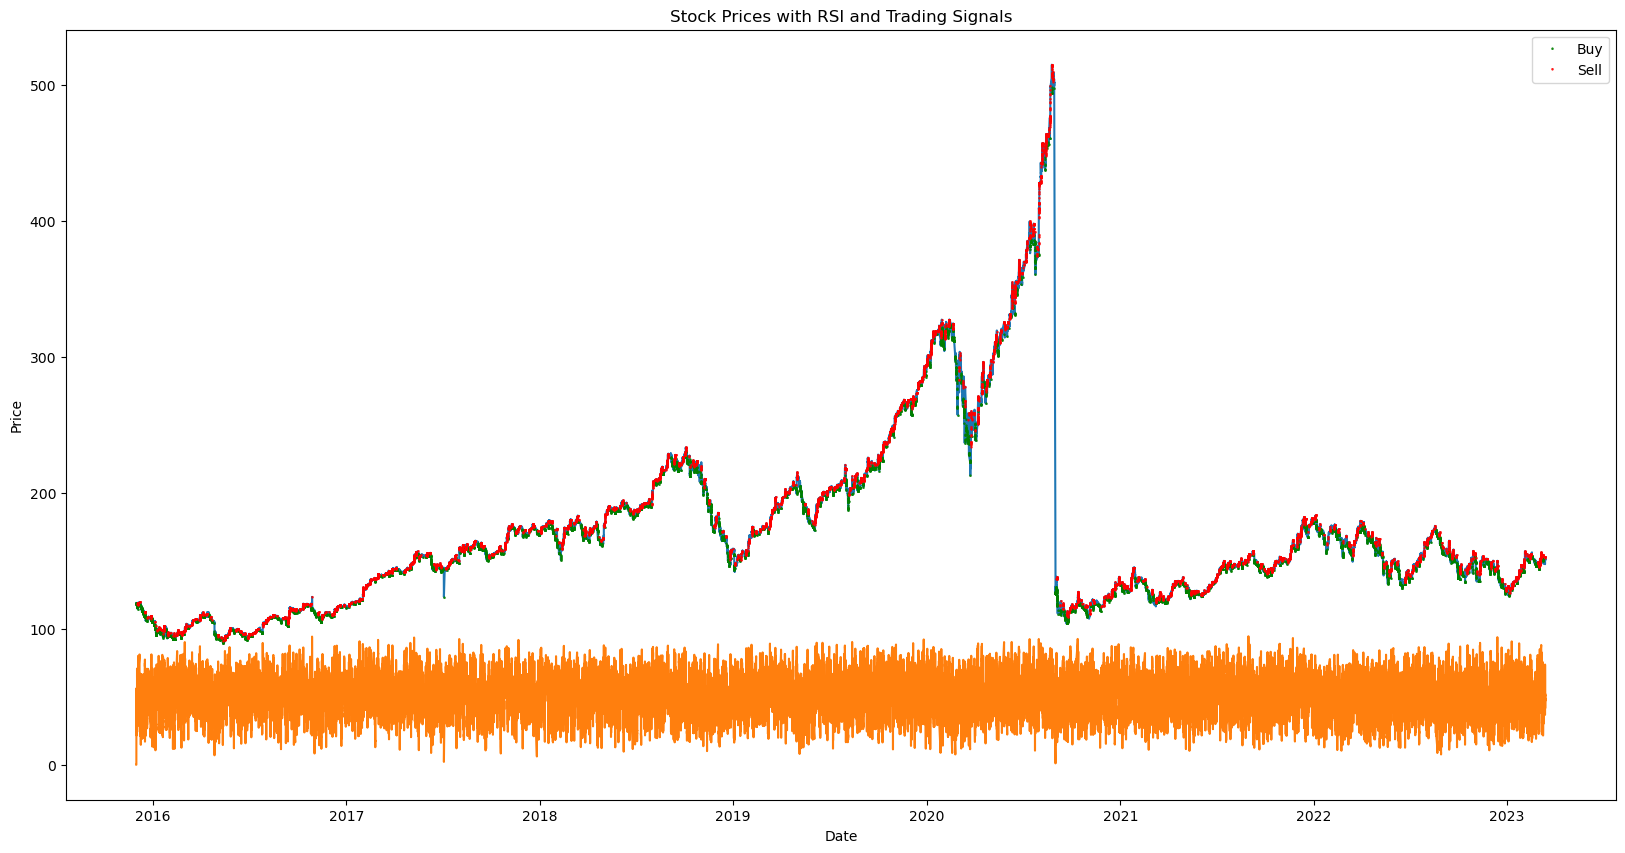

In [17]:
# Visualise Backtest Peformance

# Plot the Close price and the Bollinger Bands
plt.figure(figsize=(20,10))
plt.plot(indicators_df['Close'])
plt.plot(indicators_df['RSI'])

# Plot the signals
plt.plot(indicators_df[indicators_df['Buy Signal'] == 1.0].index, 
         indicators_df['Close'][indicators_df['Buy Signal'] == 1.0],
         '^', markersize=1, color='green', label='Buy')
plt.plot(indicators_df[indicators_df['Buy Signal'] == -1.0].index, 
         indicators_df['Close'][indicators_df['Buy Signal'] == -1.0], 
         'v', markersize=1, color='red', label='Sell')

plt.title('Stock Prices with RSI and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Theoretical Stock Price Predictions - Caculating return. 

In [67]:

# Create a new DataFrame with only the 'Close' and RSI column
appl_df = pd.DataFrame()
appl_df['close'] = df_ticker['close']
appl_df['RSI'] = indicators_df['RSI']

# Review the DataFrame
appl_df.head()


,close,RSI
Date,,
2015-12-01 09:00:00+00:00,118.94,NaN
2015-12-01 09:15:00+00:00,118.77,NaN
2015-12-01 09:30:00+00:00,118.60,NaN
2015-12-01 09:45:00+00:00,118.65,NaN
2015-12-01 10:00:00+00:00,118.55,NaN


In [23]:
# Initialize trade_type column for buys and sells
appl_df['trade_type'] = np.nan

# Initialize variable to hold the previous_price
previous_price = 0

# Initialize a cost/proceeds column for recording trade metrics
appl_df["cost/proceeds"] = np.nan


In [24]:
# Initialize share_size equals 100 and accumulated_shares equals 0
share_size = 100
accumulated_shares = 0


In [25]:
# Loop through the Pandas DataFrame and code the conditions of the trading strategy
for index, row in appl_df.iterrows():

    # buy if the previous price is 0, in other words, buy on the first day
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    if previous_price == 0:
        if row ['RSI'] < 30:
            appl_df.loc[index, "cost/proceeds"] = -(row["close"] * share_size)
            accumulated_shares += share_size
            print(f"{index}: Bought {share_size} shares, total {accumulated_shares}")

    # buy if the current day price is less than the previous day price
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    elif row["close"] < previous_price:
        if row ['RSI'] < 30:
            appl_df.loc[index, "cost/proceeds"] = -(row["close"] * share_size)
            accumulated_shares += share_size
            print(f"{index}: Bought {share_size} shares, total {accumulated_shares}")

    # sell if the current day price is greater than the previous day price
    elif row["close"] > previous_price and accumulated_shares > 0 and index != appl_df.index[-1]:
        if row ['RSI'] > 70:
            appl_df.loc[index, "cost/proceeds"] = row["close"] * share_size
            print(f"{index}: Sold {accumulated_shares} shares")
            accumulated_shares -= share_size
            # accumulated_shares = 0

    # else hold if the current day price is equal to the previous day price
    else:
        appl_df.loc[index, "trade_type"] = "hold"

    # set the previous_price variable to the close price of the current row
    previous_price = row["close"]

    # if the index is the last index of the Dataframe, sell
    # set the cost/proceeds column equal to the row close price multiplied
    # by the accumulated_shares
    if index == appl_df.index[-1]:
        appl_df.loc[index, "trade_type"] = "sell"
        appl_df.loc[index, "cost/proceeds"] = row["close"] * accumulated_shares
        print(f"{index}: Sold {accumulated_shares} shares")
        accumulated_shares = 0


2015-12-01 09:15:00+00:00: Bought 100 shares, total 100
2015-12-01 09:30:00+00:00: Bought 100 shares, total 200
2015-12-01 10:00:00+00:00: Bought 100 shares, total 300
2015-12-01 10:30:00+00:00: Bought 100 shares, total 400
2015-12-01 18:00:00+00:00: Bought 100 shares, total 500
2015-12-01 18:15:00+00:00: Bought 100 shares, total 600
2015-12-01 18:45:00+00:00: Bought 100 shares, total 700
2015-12-01 19:00:00+00:00: Bought 100 shares, total 800
2015-12-01 19:15:00+00:00: Bought 100 shares, total 900
2015-12-01 19:30:00+00:00: Bought 100 shares, total 1000
2015-12-01 20:15:00+00:00: Bought 100 shares, total 1100
2015-12-02 13:30:00+00:00: Bought 100 shares, total 1200
2015-12-02 13:45:00+00:00: Bought 100 shares, total 1300
2015-12-02 15:30:00+00:00: Sold 1300 shares
2015-12-02 19:30:00+00:00: Bought 100 shares, total 1300
2015-12-02 19:45:00+00:00: Bought 100 shares, total 1400
2015-12-02 20:15:00+00:00: Bought 100 shares, total 1500
2015-12-02 20:30:00+00:00: Bought 100 shares, total 1

In [30]:
#Calculate the total profit or loss for the trading algorithm by summing the values in the "cost/proceeds" column. 

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = round(appl_df["cost/proceeds"].sum(), 2)

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss}.")

The total profit/loss of the trading strategy is $1052178.14.


In [50]:
# Calculate the ROI for the trades
# Initialize the variable to hold the value of the invested capital
invested_capital = 100

# Calculate the return on investment (ROI)
roi = float(round((total_profit_loss / (invested_capital)) * 100, 2))

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi}%")

The trading algorithm resulted in a return on investment of 1052178.14%


In [35]:
indicators_df['Strategy Returns'] = indicators_df['Actual Returns'] * indicators_df['Buy Signal'].shift()
indicators_df = indicators_df.dropna()

display(indicators_df.head())
display(indicators_df.tail())

,Close,Actual Returns,Short,Long,RSI,20 Day MA,Upper Band,Lower Band,Buy Signal,Strategy Returns
Date,,,,,,,,,,
2015-12-01 13:45:00+00:00,118.6300,0.000084,118.738404,118.738258,41.261045,118.73800,119.017518,118.458482,0.0,0.0
2015-12-01 14:00:00+00:00,118.7900,0.001349,118.741383,118.740976,50.339944,118.73050,118.994834,118.466166,0.0,0.0
2015-12-01 14:15:00+00:00,118.7200,-0.000589,118.740193,118.739919,46.922871,118.72800,118.991706,118.464294,0.0,-0.0
2015-12-01 14:30:00+00:00,118.2528,-0.003935,118.714018,118.716330,31.536302,118.71064,119.045846,118.375434,0.0,-0.0
2015-12-01 14:45:00+00:00,118.6500,0.003359,118.710693,118.713236,47.344771,118.71064,119.045846,118.375434,0.0,0.0


,Close,Actual Returns,Short,Long,RSI,20 Day MA,Upper Band,Lower Band,Buy Signal,Strategy Returns
Date,,,,,,,,,,
2023-03-13 23:00:00+00:00,150.90,-0.000265,150.483311,150.670525,50.062596,150.989945,152.262068,149.717822,0.0,-0.0
2023-03-13 23:15:00+00:00,150.66,-0.001590,150.486810,150.670421,45.476650,150.911445,152.047902,149.774988,0.0,-0.0
2023-03-13 23:30:00+00:00,150.84,0.001195,150.493804,150.672108,49.232814,150.845100,151.815796,149.874404,0.0,0.0
2023-03-13 23:45:00+00:00,150.90,0.000398,150.501847,150.674376,50.457992,150.784380,151.551308,150.017452,0.0,0.0
2023-03-14 08:00:00+00:00,150.95,0.000331,150.510722,150.677118,51.508230,150.724880,151.163242,150.286518,0.0,0.0


<AxesSubplot:xlabel='Date'>

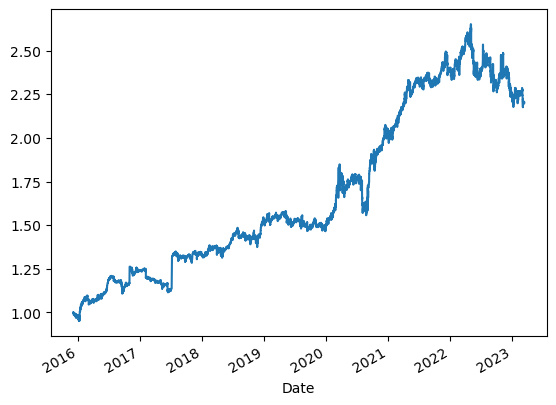

In [36]:
(1 + indicators_df['Strategy Returns']).cumprod().plot()


In [37]:
# Assign a copy of the RSI columns to a features DataFrame called X 
X = indicators_df[['RSI']].shift().dropna()

# Assign Buy Signals columns to a features DataFrame called Y
y = indicators_df['Buy Signal']
display(X.head())
display(y.value_counts())

,RSI
Date,
2015-12-01 14:00:00+00:00,41.261045
2015-12-01 14:15:00+00:00,50.339944
2015-12-01 14:30:00+00:00,46.922871
2015-12-01 14:45:00+00:00,31.536302
2015-12-01 15:00:00+00:00,47.344771


 0.0    98225
-1.0     8851
 1.0     6455
Name: Buy Signal, dtype: int64

### Split the data into training and testing using time series split

In [65]:
# Select the start of the training period
training_begin = X.index.min()

# Select the ending period for the training data with an offset of 12 months
training_end = X.index.max() + DateOffset(months=12)


In [39]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,RSI
Date,
2015-12-01 14:00:00+00:00,41.261045
2015-12-01 14:15:00+00:00,50.339944
2015-12-01 14:30:00+00:00,46.922871
2015-12-01 14:45:00+00:00,31.536302
2015-12-01 15:00:00+00:00,47.344771


In [40]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,RSI
Date,
2016-12-01 15:00:00+00:00,45.677100
2016-12-01 15:15:00+00:00,48.496482
2016-12-01 15:30:00+00:00,36.935643
2016-12-01 15:45:00+00:00,22.880283
2016-12-01 16:00:00+00:00,38.642668


Scacling the Data

In [41]:

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

As we want to predictBuy/sell Signal, we will go ahead with the classification approach and use SVC classifier from SKLearns Ssupport vector machine (SVM) learning method o fit the training data and make predictions based on the testing data.

In [42]:
# From SVM, instantiate SVC classifier model instance
svm_model = SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
print(svm_pred)

[0. 0. 0. ... 0. 0. 0.]


#### Review the classification report associated with the `SVC` model predictions. 

In [43]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.78      0.68      0.72       969
         0.0       0.96      0.97      0.96     13095
         1.0       0.77      0.71      0.74       975

    accuracy                           0.93     15039
   macro avg       0.84      0.79      0.81     15039
weighted avg       0.93      0.93      0.93     15039



#### Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [44]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=y_train.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = y_train

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2015-12-01 14:00:00+00:00,0.0,0.0,0.0
2015-12-01 14:15:00+00:00,0.0,0.0,0.0
2015-12-01 14:30:00+00:00,0.0,0.0,0.0
2015-12-01 14:45:00+00:00,0.0,0.0,0.0
2015-12-01 15:00:00+00:00,0.0,0.0,0.0


,Predicted,Actual Returns,Strategy Returns
Date,,,
2016-12-01 13:00:00+00:00,0.0,0.0,0.0
2016-12-01 13:15:00+00:00,0.0,0.0,0.0
2016-12-01 13:30:00+00:00,0.0,0.0,0.0
2016-12-01 13:45:00+00:00,0.0,0.0,0.0
2016-12-01 14:00:00+00:00,0.0,0.0,0.0


#### Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

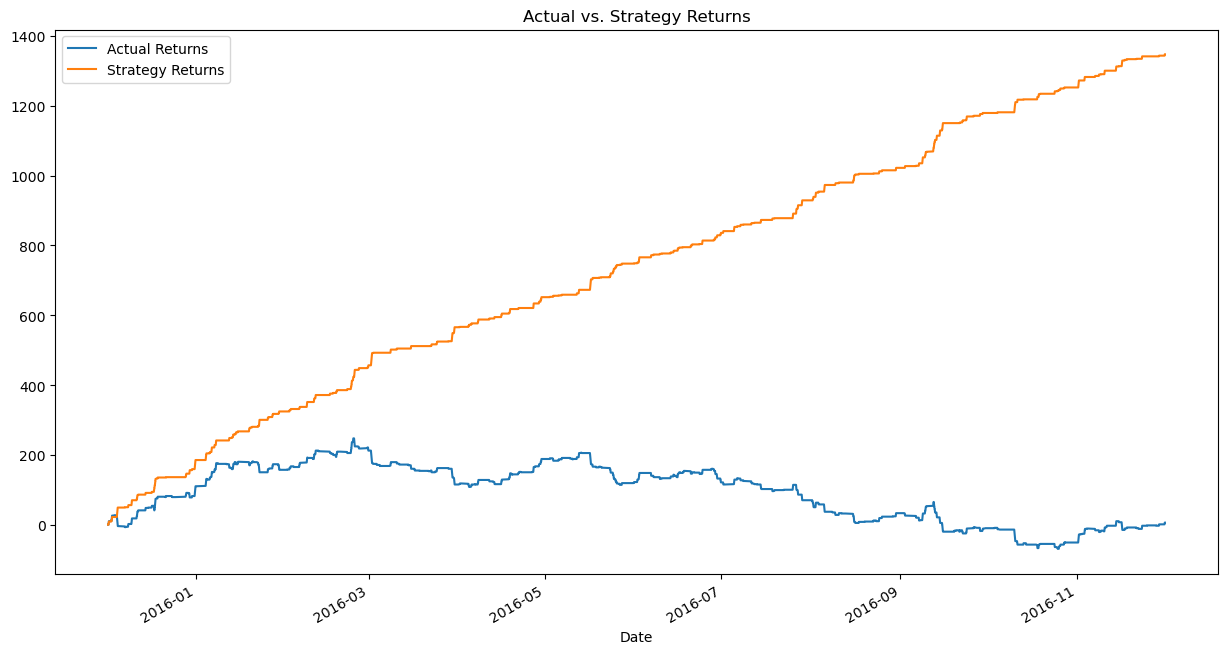

<Figure size 640x480 with 0 Axes>

In [45]:
# Plot the actual returns versus the strategy returns
((1 + predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('Actual vs. Strategy Returns')
plt.show()

plt.savefig('Actual vs. Strategy Returns.png')

#### Backtesting a Machine Learning Trading Algorithm

In [46]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [51]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.80      0.68      0.73      7882
         0.0       0.95      0.97      0.96     85126
         1.0       0.75      0.69      0.72      5480

    accuracy                           0.93     98488
   macro avg       0.83      0.78      0.81     98488
weighted avg       0.93      0.93      0.93     98488



#### Create a predictions DataFrame from back testing that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [52]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
backtest_predictions_df = pd.DataFrame(index=y_test.index)

# Add the SVM model predictions to the DataFrame
backtest_predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
backtest_predictions_df['Actual Returns'] = y_test

# Add the strategy returns to the DataFrame
backtest_predictions_df['Strategy Returns'] = backtest_predictions_df['Actual Returns'] * backtest_predictions_df['Predicted']

# Review the DataFrame
display(backtest_predictions_df.head())
display(backtest_predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2016-12-01 15:00:00+00:00,0.0,0.0,0.0
2016-12-01 15:15:00+00:00,0.0,0.0,0.0
2016-12-01 15:30:00+00:00,0.0,1.0,0.0
2016-12-01 15:45:00+00:00,1.0,0.0,0.0
2016-12-01 16:00:00+00:00,0.0,0.0,0.0


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-03-13 23:00:00+00:00,0.0,0.0,0.0
2023-03-13 23:15:00+00:00,0.0,0.0,0.0
2023-03-13 23:30:00+00:00,0.0,0.0,0.0
2023-03-13 23:45:00+00:00,0.0,0.0,0.0
2023-03-14 08:00:00+00:00,0.0,0.0,0.0


#### Create a cumulative return plot that shows the backtested actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

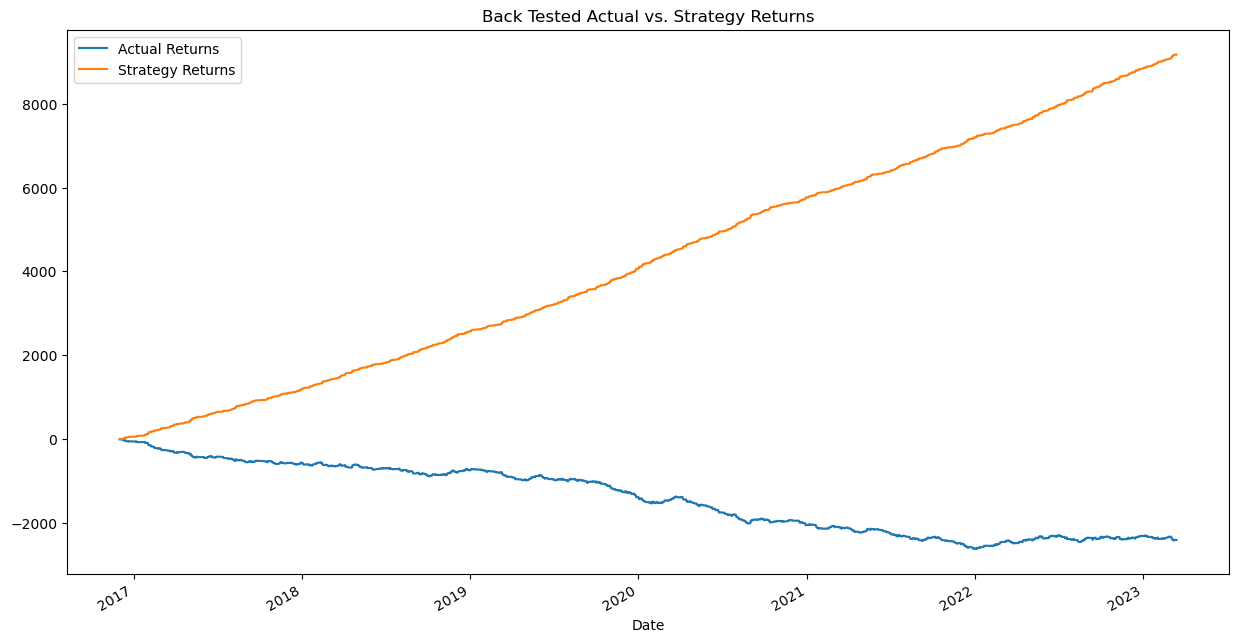

In [53]:
# Plot the actual returns versus the strategy returns
((1 + backtest_predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('Back Tested Actual vs. Strategy Returns')
plt.show()


### Using Alternative mode to see if we can achive higher average score

In [54]:
# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_scaled, y_train)

# Use the model to make predictions on the testing data
rf_pred = rf_model.predict(X_train_scaled)

print(rf_pred)

[0. 0. 0. ... 0. 0. 0.]


In [55]:
# Use a classification report to evaluate the model using the predictions and testing data
rf_testing_report_train = classification_report(y_train, rf_pred)

# Print the classification report
print(rf_testing_report_train)

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99       969
         0.0       1.00      1.00      1.00     13095
         1.0       0.99      0.98      0.99       975

    accuracy                           1.00     15039
   macro avg       0.99      0.99      0.99     15039
weighted avg       1.00      1.00      1.00     15039



In [56]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = rf_model.predict(X_test_scaled)

In [57]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report_test = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report_test)

              precision    recall  f1-score   support

        -1.0       0.64      0.63      0.63      7882
         0.0       0.94      0.94      0.94     85126
         1.0       0.60      0.60      0.60      5480

    accuracy                           0.90     98488
   macro avg       0.73      0.72      0.72     98488
weighted avg       0.90      0.90      0.90     98488



Adaboose Model  

In [58]:
# Initiate the model instance
adaboost_model = AdaBoostClassifier()

# Fit the model using the training data
model = adaboost_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = adaboost_model.predict(X_test_scaled)

# Review the model's predicted values
print(pred)


[0. 0. 0. ... 0. 0. 0.]


In [59]:
# Use a classification report to evaluate the model using the predictions and testing data
ada_pred = classification_report(y_test, pred)

# Print the classification report
print(ada_pred)


              precision    recall  f1-score   support

        -1.0       0.51      0.92      0.66      7882
         0.0       0.98      0.90      0.94     85126
         1.0       0.71      0.77      0.74      5480

    accuracy                           0.89     98488
   macro avg       0.73      0.86      0.78     98488
weighted avg       0.92      0.89      0.90     98488



In [60]:
# Create a new empty predictions DataFrame:
# Create a predictions DataFrame
ada_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
ada_predictions_df['Predicted'] = pred

# Add the actual returns to the DataFrame
ada_predictions_df['Actual Returns'] = indicators_df['Actual Returns']

# Add the strategy returns to the DataFrame
ada_predictions_df['Strategy Returns'] = ada_predictions_df['Actual Returns'] * pred

# Review the DataFrame
ada_predictions_df


,Predicted,Actual Returns,Strategy Returns
Date,,,
2016-12-01 15:00:00+00:00,0.0,0.000454,0.000000
2016-12-01 15:15:00+00:00,0.0,-0.002539,-0.000000
2016-12-01 15:30:00+00:00,0.0,-0.006090,-0.000000
2016-12-01 15:45:00+00:00,1.0,0.003841,0.003841
2016-12-01 16:00:00+00:00,0.0,-0.001093,-0.000000
...,...,...,...
2023-03-13 23:00:00+00:00,0.0,-0.000265,-0.000000
2023-03-13 23:15:00+00:00,0.0,-0.001590,-0.000000
2023-03-13 23:30:00+00:00,0.0,0.001195,0.000000


<AxesSubplot:xlabel='Date'>

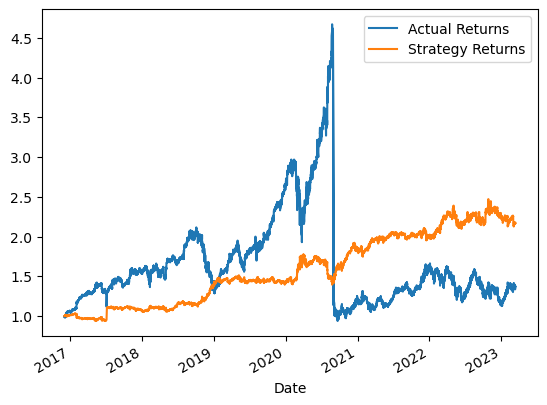

In [61]:
# Plot the actual returns versus the strategy returns
(1 + ada_predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()